# Test vacuum fluctuations
To see that measurements are quantum limited.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import cvxpy as cp

import numpy as np

from qutip import *
from joblib import Parallel, delayed

## Define operators

In [2]:
N=5

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

In [3]:
def interact(g):
    op =   g * (a.dag() * sm - a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def U_int(g, dt):
    Hint =  (-1j) *g*np.sqrt(dt) * (a.dag() * sm + a * sm.dag())
    return Hint.expm()

## Parameters and initialize vacuum state

In [4]:
# number of qubit measurements per trajectory (in total, both X and Y)
Nmeas = 80

# number of trajectories
Ntrajs = 5000

# interaction strength
g = 0.4
delta_t = 0.4
dt = delta_t

gamma = g**2

gint = np.sqrt(gamma*delta_t)

initial_cavity = fock(N, 0)

psi0 = tensor(initial_cavity, basis(2,0))

gint

0.2529822128134704

In [5]:
# gaussian centered at 0
def gauss(x, var):
    const = 1/np.sqrt(var*2*np.pi)
    return np.exp(-x**2/var /2) * const

x = np.linspace(-3,3)

## Heterodyne detection

In [49]:
# This is done simply by interleaving measurements of X and Y on the qubit

# generate interaction Hamiltonian with strength gint
Uint = U_int(g, delta_t)

nsteps = np.linspace(0,Nmeas-1,Nmeas)

qbrotmat = [rotateXY(np.pi/2,0),rotateXY(np.pi/2,np.pi/2)] # # qb rotation applied prior to qb measurement. [rotate to X, rotate to Y]
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

### Matches Gaussian with variance 2

In [95]:
def get_heterodyne_meas(weights):
    
    xrnd = np.random.rand(Nmeas)
    #xrnd = prng.rand(Nmeas)
    szexp = [[] for i in range(2)]
    results =[[] for i in range(2)]
    psi = psi0
    
    # individual qubit measurements
    for i in range(Nmeas):
        k = i % 2 # do X and Y every other round
        
        psi = qbrotmat[k] * (Uint * psi)        
        prob = expect(proj0,psi)
        
        if prob > xrnd[i]:
            # measured g
            results[k].append(-1)
            psi = (proj0 * psi).unit()
        else:
            # measured e
            results[k].append(1)
            psi = (proj1 * psi).unit()
            # go back to g
            psi = qbfeedback * psi

    return np.sum(results[0]*weights[::2]) + 1j * np.sum(results[1]*weights[1::2])

In [96]:
# define weights! this makes the difference
weights1 =  2*np.sqrt(gamma*dt)*np.exp(-nsteps*(gint**2/2))



prng = np.random.RandomState(12775425)
# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas1= Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed(get_heterodyne_meas)(weights1) for j in range(Ntrajs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 937 out of 1000 | elapsed:    2.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


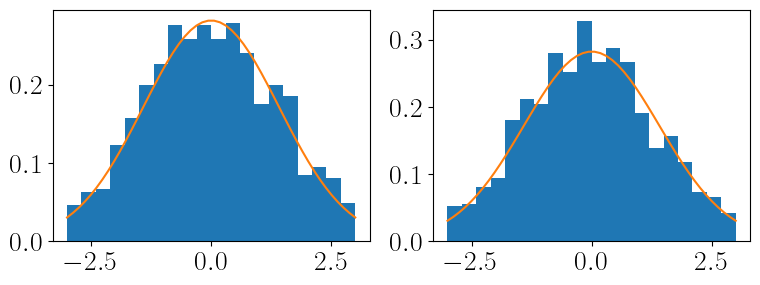

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

Nbins=20

# x and y switched
real_meas = np.real(np.array(quadmeas1))
imag_meas = np.imag(np.array(quadmeas1))

# plot real and imaginary parts of measurement results to get 1D histograms
axes[0].hist(real_meas ,Nbins,[-3,3], density=True)
axes[1].hist(imag_meas,Nbins,[-3,3], density=True)

variance_heterodyne = 2
gaussian = gauss(x,variance_heterodyne)

axes[0].plot(x,gaussian)
axes[1].plot(x,gaussian)
plt.show()

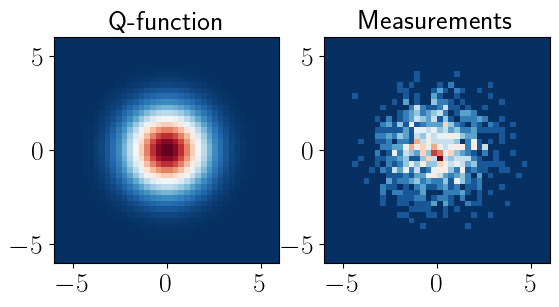

In [59]:
Nbins=40
k=6

xvec = np.linspace(-k,k,Nbins)
# will use different values for g below 
Q_comp = qfunc(initial_cavity, xvec, xvec,g=1) # ideal Q-function

hist, xedges, yedges = np.histogram2d(real_meas, imag_meas, Nbins,range=[[-k,k],[-k,k]],normed=True)

fig, ax = plt.subplots(1,2)
fig1 = ax[0].imshow(Q_comp,extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[0].set_title('Q-function')
### TRANSPOSE
hist = hist.T

fig2=ax[1].imshow(hist, extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[1].set_title('Measurements');

### Matches Gaussian with variance 1

In [60]:
nsteps = np.linspace(0,Nmeas-1,Nmeas)

weights2 =  np.sqrt(gamma*dt*2)*np.exp(-nsteps*(gint**2/2))

# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas2 = Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed(get_heterodyne_meas)(weights2) for j in range(Ntrajs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.6s finished


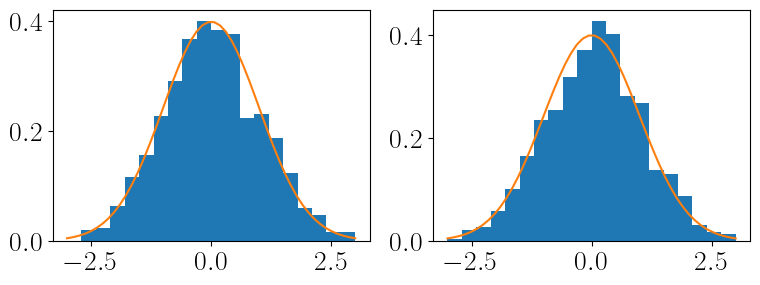

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

Nbins=20

# x and y switched
real_meas = np.real(np.array(quadmeas2))
imag_meas = np.imag(np.array(quadmeas2))

# plot real and imaginary parts of measurement results to get 1D histograms
axes[0].hist(real_meas ,Nbins,[-3,3], density=True)
axes[1].hist(imag_meas,Nbins,[-3,3], density=True)

variance_heterodyne = 1
gaussian = gauss(x,variance_heterodyne)

axes[0].plot(x,gaussian)
axes[1].plot(x,gaussian)
plt.show()

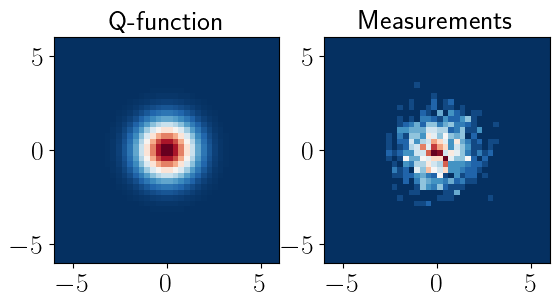

In [63]:
Nbins=40
k=6

xvec = np.linspace(-k,k,Nbins)
Q_comp = qfunc(initial_cavity, xvec, xvec,g=np.sqrt(2)) # ideal Q-function

hist, xedges, yedges = np.histogram2d(real_meas, imag_meas, Nbins,range=[[-k,k],[-k,k]],normed=True)

fig, ax = plt.subplots(1,2)
fig1 = ax[0].imshow(Q_comp,extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[0].set_title('Q-function')
### TRANSPOSE
hist = hist.T

fig2=ax[1].imshow(hist, extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[1].set_title('Measurements');

### Matches Gaussian with variance 1/2

In [64]:
weights3 =  np.sqrt(gamma*dt)*np.exp(-nsteps*(gint**2/2))

# NOTE: do NOT use backend multiprocessing here, it doesn't deal with xrnd = np.random.rand(Nmeas) properly
quadmeas3 = Parallel(n_jobs=-1, verbose=5, backend="loky")(delayed(get_heterodyne_meas)(weights3) for j in range(Ntrajs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.6s finished


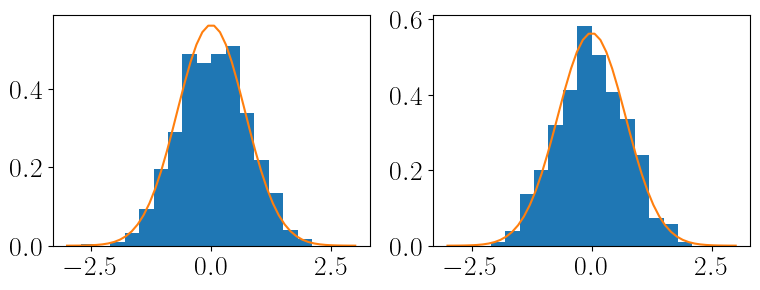

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

Nbins=20

# x and y switched
real_meas = np.real(np.array(quadmeas3))
imag_meas = np.imag(np.array(quadmeas3))

# plot real and imaginary parts of measurement results to get 1D histograms
axes[0].hist(real_meas ,Nbins,[-3,3], density=True)
axes[1].hist(imag_meas,Nbins,[-3,3], density=True)

variance_heterodyne = 1/2
gaussian = gauss(x,variance_heterodyne)

axes[0].plot(x,gaussian)
axes[1].plot(x,gaussian)
plt.show()

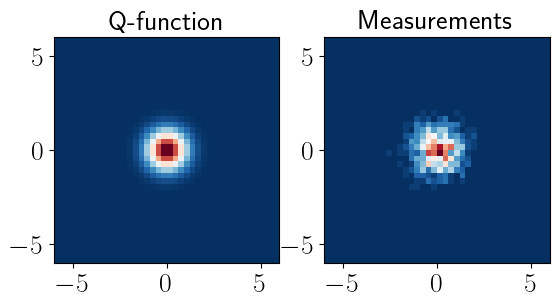

In [66]:
Nbins=40
k=6

xvec = np.linspace(-k,k,Nbins)
Q_comp = qfunc(initial_cavity, xvec, xvec,g=2) # ideal Q-function

hist, xedges, yedges = np.histogram2d(real_meas, imag_meas, Nbins,range=[[-k,k],[-k,k]],normed=True)

fig, ax = plt.subplots(1,2)
fig1 = ax[0].imshow(Q_comp,extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[0].set_title('Q-function')
### TRANSPOSE
hist = hist.T

fig2=ax[1].imshow(hist, extent=[-k,k,-k,k], cmap=cm.RdBu_r)
ax[1].set_title('Measurements');

## Homodyne

## Matches Gaussian with variance 1/2

In [92]:
# seed 
nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(gint/np.sqrt(4))*np.exp(-nsteps*(gint**2/2))

# generate interaction Hamiltonian with strength gint

# get measurement histogram for one homodyne angle
def get_homodyne_meas():
    
    ### simulate tomography ###
    rotangl = 0
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = [] # store weighted measurement results

    xrnd = np.random.rand(Nmeas)

    results = []
    psi = psi0

    for i in range(Nmeas):
            U = qbrotmat * Uint 
            
            psi = U * psi 
            prob = expect(proj0,psi)          

            
            if prob > xrnd[i]:
                # measured g
                results.append(-1)
                psi = (proj0 * psi).unit()
            else:
                results.append(1)
                # measured e
                psi = (proj1 * psi).unit()
                # go back to g
                psi = qbfeedback * psi
    

    return np.sum(results*weights)


Ntrajs = 1000
measurements = Parallel(n_jobs=-1, verbose=0, backend="loky")(delayed(get_homodyne_meas)() for j in range(Ntrajs))

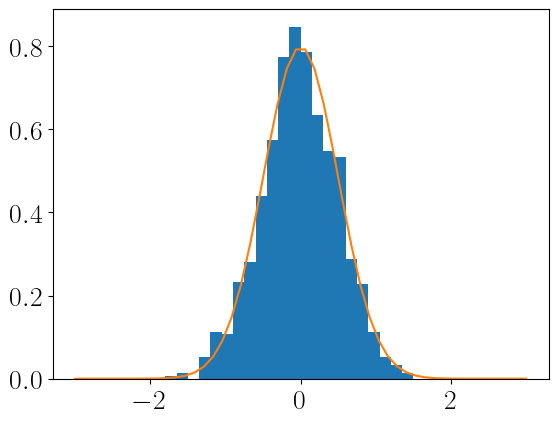

In [94]:
plt.hist(measurements,Nbins,[-3,3], density=True)
variance_homodyne = 1/4
prob = gauss(x,variance_homodyne)
plt.plot(x,prob);